In [4]:
%pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Qgth79upN58d25jLRmkD")
project = rf.workspace("v-medithon").project("bmi-3ydem-tgi6f")
version = project.version(1)
dataset = version.download("multiclass")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


loading Roboflow workspace...
loading Roboflow project...
loading Roboflow project...



Extracting Dataset Version Zip to BMI-1 in multiclass:: 100%|██████████| 9648/9648 [00:04<00:00, 2266.40it/s]
Extracting Dataset Version Zip to BMI-1 in multiclass:: 100%|██████████| 9648/9648 [00:04<00:00, 2266.40it/s]


In [19]:
%pip install ultralytics

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import pandas as pd
import shutil
from pathlib import Path
from ultralytics import YOLO
import torch
import yaml

In [2]:
base_dir = "BMI-1"
output_dir = os.path.join(base_dir, "yolo_dataset")
class_names = ["Normal-weight", "Overweight", "Mild-obesity", "Moderate-obesity", "Severe-obesity"]

In [5]:
def organize_dataset():
    """Organize the dataset into YOLO format"""
    for split in ['train', 'valid']:
        csv_path = os.path.join(base_dir, split, '_classes.csv')
        if not os.path.exists(csv_path):
            print(f"CSV file not found: {csv_path}")
            continue
            
        df = pd.read_csv(csv_path)
        print(f"Processing {split} set with {len(df)} images...")
        
        for idx, row in df.iterrows():
            filename = row['filename']
            src_path = os.path.join(base_dir, split, filename)
            
            if not os.path.exists(src_path):
                print(f"Image not found: {src_path}")
                continue
                
            for class_name in class_names:
                if class_name in df.columns and row[class_name] == 1:
                    dest_dir = os.path.join(output_dir, split, class_name)
                    os.makedirs(dest_dir, exist_ok=True)
                    dest_path = os.path.join(dest_dir, filename)
                    shutil.copy2(src_path, dest_path)
                    break

organize_dataset()

Processing train set with 8448 images...
Processing valid set with 1194 images...
Processing valid set with 1194 images...


In [24]:
data_yaml = {
    'path': output_dir,
    'train': 'train',
    'val': 'valid',
    'nc': len(class_names),
    'names': {i: name for i, name in enumerate(class_names)}
}
yaml_path = os.path.join(output_dir, 'data.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

In [6]:
import torch
from ultralytics import YOLO

model = YOLO("yolov8n-cls.pt")  # Classification model
print("Model loaded successfully!")

Model loaded successfully!


In [31]:
# Train the model for BMI classification
results = model.train(
    data=output_dir,  
    epochs=50,       
    imgsz=224,        
    batch=16,         
    lr0=0.01,         
    lrf=0.01,         
    momentum=0.937,   
    weight_decay=0.0005,  
    warmup_epochs=3,  
    warmup_momentum=0.8,  
    warmup_bias_lr=0.1,   
    patience=15,     
    save=True,       
    save_period=10,  
    project='bmi_classification',  
    name='yolov8_bmi_5class_v2',   
    exist_ok=True,   
    verbose=True,    
    seed=42,         
    workers=4,        
    optimizer='SGD',  
    cos_lr=True,      
    amp=True,        
    dropout=0.0,     
    label_smoothing=0.1,
    hsv_h=0.015,      
    hsv_s=0.7,        
    hsv_v=0.4,        
    degrees=10.0,     
    translate=0.1,    
    scale=0.5,       
    shear=0.0,       
    perspective=0.0, 
    flipud=0.0,      
    fliplr=0.5,      
    mixup=0.1,       
    copy_paste=0.1,  
)

print("Training completed!")
print(f"Best model saved at: {results.save_dir}")

WARNING 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.191  Python-3.9.13 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=BMI-1\yolo_dataset, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_bmi_5class_v2, nbs=64, nms=False, opset=None, op

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def predict_bmi_class(image_path, model_path=None):
    """
    Predict BMI class from an image
    
    Args:
        image_path: Path to the image file
        model_path: Path to trained model (optional, will use best model if None)
    
    Returns:
        tuple: (predicted_class, confidence, all_probabilities)
    """
    try:
        # Load the best model if path not provided
        if model_path is None:
            # Try to find the best model from training
            best_model_path = os.path.join("bmi_classification", "yolov8_bmi_5class_v2", "weights", "best.pt")
            if os.path.exists(best_model_path):
                model_path = best_model_path
            else:
                print("Using current model...")
                trained_model = model
        else:
            trained_model = YOLO(model_path)
        
        if model_path:
            trained_model = YOLO(model_path)
        
        # Make prediction
        results = trained_model(image_path)
        
        # Extract results
        for result in results:
            if hasattr(result, 'probs') and result.probs is not None:
                probs = result.probs
                top_class_idx = probs.top1
                confidence = probs.top1conf.item()
                predicted_class = class_names[top_class_idx]
                
                # Get all probabilities
                all_probs = probs.data.cpu().numpy()
                
                return predicted_class, confidence, all_probs
        
        return None, None, None
        
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None, None

def visualize_prediction(image_path, show_probabilities=True):
    """
    Visualize image with BMI prediction results
    
    Args:
        image_path: Path to the image file
        show_probabilities: Whether to show probability distribution
    """
    # Make prediction
    predicted_class, confidence, all_probs = predict_bmi_class(image_path)
    
    if predicted_class is None:
        print("Failed to make prediction")
        return
    
    # Create figure
    if show_probabilities:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
    
    # Display image
    img = Image.open(image_path)
    ax1.imshow(img)
    ax1.set_title(f"Predicted: {predicted_class}\nConfidence: {confidence:.3f}", 
                  fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Display probability distribution
    if show_probabilities and all_probs is not None:
        bars = ax2.bar(class_names, all_probs)
        ax2.set_title('BMI Class Probabilities', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Probability')
        ax2.set_ylim(0, 1)
        
        # Color the highest bar differently
        max_idx = np.argmax(all_probs)
        bars[max_idx].set_color('red')
        
        # Add value labels on bars
        for i, (bar, prob) in enumerate(zip(bars, all_probs)):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{prob:.3f}', ha='center', va='bottom', fontsize=10)
        
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\n{'='*50}")
    print(f"BMI CLASSIFICATION RESULTS")
    print(f"{'='*50}")
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.4f}")
    
    if all_probs is not None:
        print(f"\nAll Class Probabilities:")
        for i, (class_name, prob) in enumerate(zip(class_names, all_probs)):
            print(f"  {class_name}: {prob:.4f}")

print("BMI prediction functions ready!")

BMI prediction functions ready!


In [8]:
# Test the model with sample images from each class
import glob

def test_model_on_samples():
    """Test the model on sample images from each BMI class"""
    print("Testing BMI Classification Model...")
    print("="*60)
    
    # Find sample images from each class
    test_samples = []
    for class_name in class_names:
        class_path = os.path.join(output_dir, "valid", class_name, "*")
        class_images = glob.glob(class_path)
        if class_images:
            # Take first image from each class
            test_samples.append((class_images[0], class_name))
    
    if not test_samples:
        print("No test images found! Please check the dataset organization.")
        return
    
    # Test each sample
    correct_predictions = 0
    total_predictions = len(test_samples)
    
    for i, (image_path, true_class) in enumerate(test_samples):
        print(f"\nTest {i+1}/{total_predictions}")
        print(f"True Class: {true_class}")
        print(f"Image: {os.path.basename(image_path)}")
        
        # Make prediction
        predicted_class, confidence, all_probs = predict_bmi_class(image_path)
        
        if predicted_class:
            print(f"Predicted: {predicted_class} (Confidence: {confidence:.3f})")
            
            if predicted_class == true_class:
                print("✓ CORRECT")
                correct_predictions += 1
            else:
                print("✗ INCORRECT")
        else:
            print("✗ PREDICTION FAILED")
    
    # Calculate accuracy
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f"\n{'='*60}")
    print(f"SUMMARY")
    print(f"{'='*60}")
    print(f"Total Tests: {total_predictions}")
    print(f"Correct Predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy:.2%}")
    
    return test_samples

# Run the test
test_samples = test_model_on_samples()

Testing BMI Classification Model...

Test 1/5
True Class: Normal-weight
Image: img_1007_bmp.rf.98426d1999e22ebfcf56e842da93e639.jpg


image 1/1 c:\Users\Dell\Documents\GitHub\GlucoZap\ml\bmi\BMI-1\yolo_dataset\valid\Normal-weight\img_1007_bmp.rf.98426d1999e22ebfcf56e842da93e639.jpg: 224x224 Normal-weight 1.00, Overweight 0.00, Mild-obesity 0.00, Moderate-obesity 0.00, Severe-obesity 0.00, 2.7ms
Speed: 12.9ms preprocess, 2.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
image 1/1 c:\Users\Dell\Documents\GitHub\GlucoZap\ml\bmi\BMI-1\yolo_dataset\valid\Normal-weight\img_1007_bmp.rf.98426d1999e22ebfcf56e842da93e639.jpg: 224x224 Normal-weight 1.00, Overweight 0.00, Mild-obesity 0.00, Moderate-obesity 0.00, Severe-obesity 0.00, 2.7ms
Speed: 12.9ms preprocess, 2.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
Predicted: Mild-obesity (Confidence: 0.996)
✗ INCORRECT

Test 2/5
True Class: Overweight
Image: img_1023_bmp.rf.0ba4767fdc08b5aef01420c0061082a8

Testing custom image prediction...

image 1/1 C:\Users\Dell\Documents\GitHub\GlucoZap\ml\bmi\BMI-1\valid\img_19_bmp.rf.2b74eee5c1db92a42e302fba4ad52943.jpg: 224x224 Overweight 0.44, Moderate-obesity 0.30, Mild-obesity 0.13, Normal-weight 0.13, Severe-obesity 0.01, 13.5ms
Speed: 2.0ms preprocess, 13.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
image 1/1 C:\Users\Dell\Documents\GitHub\GlucoZap\ml\bmi\BMI-1\valid\img_19_bmp.rf.2b74eee5c1db92a42e302fba4ad52943.jpg: 224x224 Overweight 0.44, Moderate-obesity 0.30, Mild-obesity 0.13, Normal-weight 0.13, Severe-obesity 0.01, 13.5ms
Speed: 2.0ms preprocess, 13.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


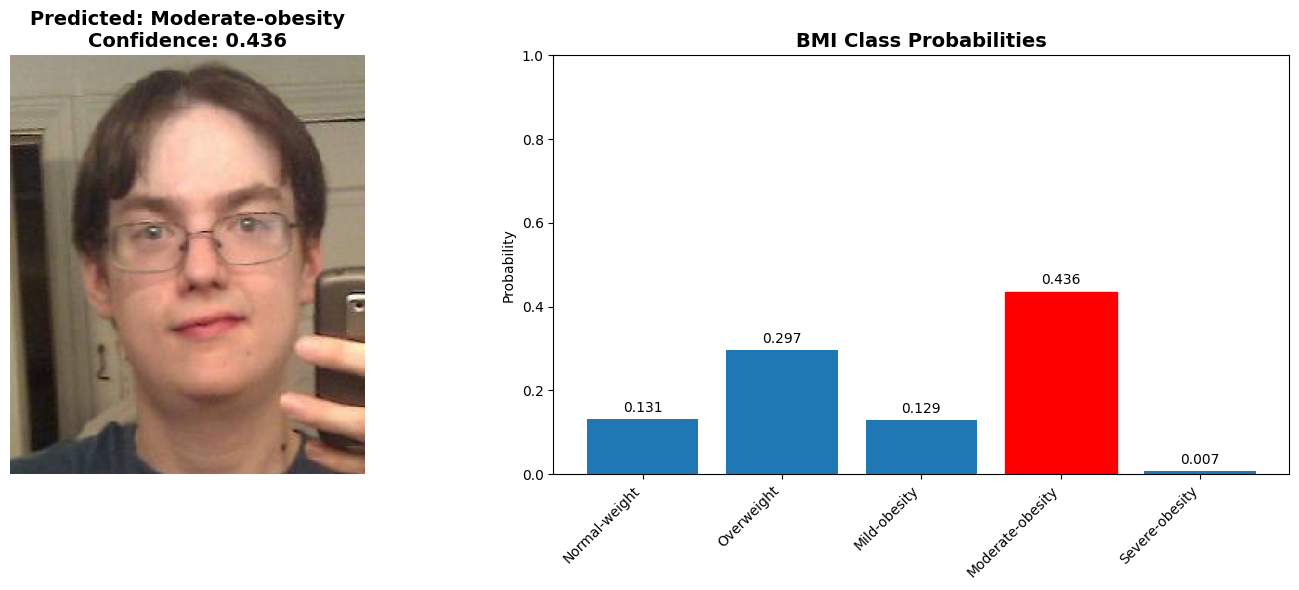


BMI CLASSIFICATION RESULTS
Image: img_19_bmp.rf.2b74eee5c1db92a42e302fba4ad52943.jpg
Predicted Class: Moderate-obesity
Confidence: 0.4357

All Class Probabilities:
  Normal-weight: 0.1311
  Overweight: 0.2968
  Mild-obesity: 0.1291
  Moderate-obesity: 0.4357
  Severe-obesity: 0.0072


In [9]:

sample_image_path = r"C:\Users\Dell\Documents\GitHub\GlucoZap\ml\bmi\BMI-1\valid\img_19_bmp.rf.2b74eee5c1db92a42e302fba4ad52943.jpg"

# Check if the image exists
if os.path.exists(sample_image_path):
    print("Testing custom image prediction...")
    visualize_prediction(sample_image_path, show_probabilities=True)
else:
    print(f"Image not found: {sample_image_path}")
    print("Please update the path with a valid image file.")
    
    if 'test_samples' in locals() and test_samples:
        print("\nUsing sample from test set instead:")
        sample_path = test_samples[0][0] 
        visualize_prediction(sample_path, show_probabilities=True)

In [11]:
import cv2
import mediapipe as mp
import numpy as np
from matplotlib import pyplot as plt

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

def create_face_mesh_image(image_path):
    """Create face mesh overlay on the input image"""
    try:
        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            return None, None, False
        
        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Initialize face mesh
        with mp_face_mesh.FaceMesh(
            static_image_mode=True,
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5) as face_mesh:
            
            # Process the image
            results = face_mesh.process(image_rgb)
            
            # Create a copy for drawing
            annotated_image = image_rgb.copy()
            face_detected = False
            
            # Draw face mesh if detected
            if results.multi_face_landmarks:
                face_detected = True
                for face_landmarks in results.multi_face_landmarks:
                    # Draw face mesh
                    mp_drawing.draw_landmarks(
                        image=annotated_image,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_CONTOURS,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())
                    
                    # Draw face mesh tesselation
                    mp_drawing.draw_landmarks(
                        image=annotated_image,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_TESSELATION,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
            
            return image_rgb, annotated_image, face_detected
            
    except Exception as e:
        print(f"Error creating face mesh: {e}")
        return None, None, False

def visualize_with_face_mesh(image_path, show_probabilities=True):
    """Display existing BMI prediction with face mesh image added"""
    # Make BMI prediction using existing function
    predicted_class, confidence, all_probs = predict_bmi_class(image_path)
    
    if predicted_class is None:
        print("Failed to make prediction")
        return
    
    # Create face mesh
    original_image, face_mesh_image, face_detected = create_face_mesh_image(image_path)
    
    if original_image is None:
        # Fallback to original visualization if face mesh fails
        visualize_prediction(image_path, show_probabilities)
        return
    
    # Create figure - just add one more panel for face mesh
    if show_probabilities:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original image with prediction
    ax1.imshow(original_image)
    ax1.set_title(f"Predicted: {predicted_class}\nConfidence: {confidence:.3f}", 
                  fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Face mesh image
    ax2.imshow(face_mesh_image)
    ax2.set_title("Face Mesh", fontsize=14, fontweight='bold')
    ax2.axis('off')
    
    # Probability distribution
    if show_probabilities and all_probs is not None:
        bars = ax3.bar(class_names, all_probs)
        ax3.set_title('BMI Class Probabilities', fontsize=14, fontweight='bold')
        ax3.set_ylabel('Probability')
        ax3.set_ylim(0, 1)
        
        # Color the highest bar
        max_idx = np.argmax(all_probs)
        bars[max_idx].set_color('red')
        
        # Add value labels
        for i, (bar, prob) in enumerate(zip(bars, all_probs)):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{prob:.3f}', ha='center', va='bottom', fontsize=10)
        
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    print(f"\n{'='*50}")
    print(f"BMI CLASSIFICATION RESULTS")
    print(f"{'='*50}")
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.4f}")
    
    if all_probs is not None:
        print(f"\nAll Class Probabilities:")
        for i, (class_name, prob) in enumerate(zip(class_names, all_probs)):
            print(f"  {class_name}: {prob:.4f}")

print("Face mesh functions ready!")

Face mesh functions ready!


Testing with face mesh...

image 1/1 C:\Users\Dell\Documents\GitHub\GlucoZap\ml\bmi\BMI-1\valid\img_19_bmp.rf.2b74eee5c1db92a42e302fba4ad52943.jpg: 224x224 Overweight 0.44, Moderate-obesity 0.30, Mild-obesity 0.13, Normal-weight 0.13, Severe-obesity 0.01, 6.6ms
Speed: 2.8ms preprocess, 6.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
image 1/1 C:\Users\Dell\Documents\GitHub\GlucoZap\ml\bmi\BMI-1\valid\img_19_bmp.rf.2b74eee5c1db92a42e302fba4ad52943.jpg: 224x224 Overweight 0.44, Moderate-obesity 0.30, Mild-obesity 0.13, Normal-weight 0.13, Severe-obesity 0.01, 6.6ms
Speed: 2.8ms preprocess, 6.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


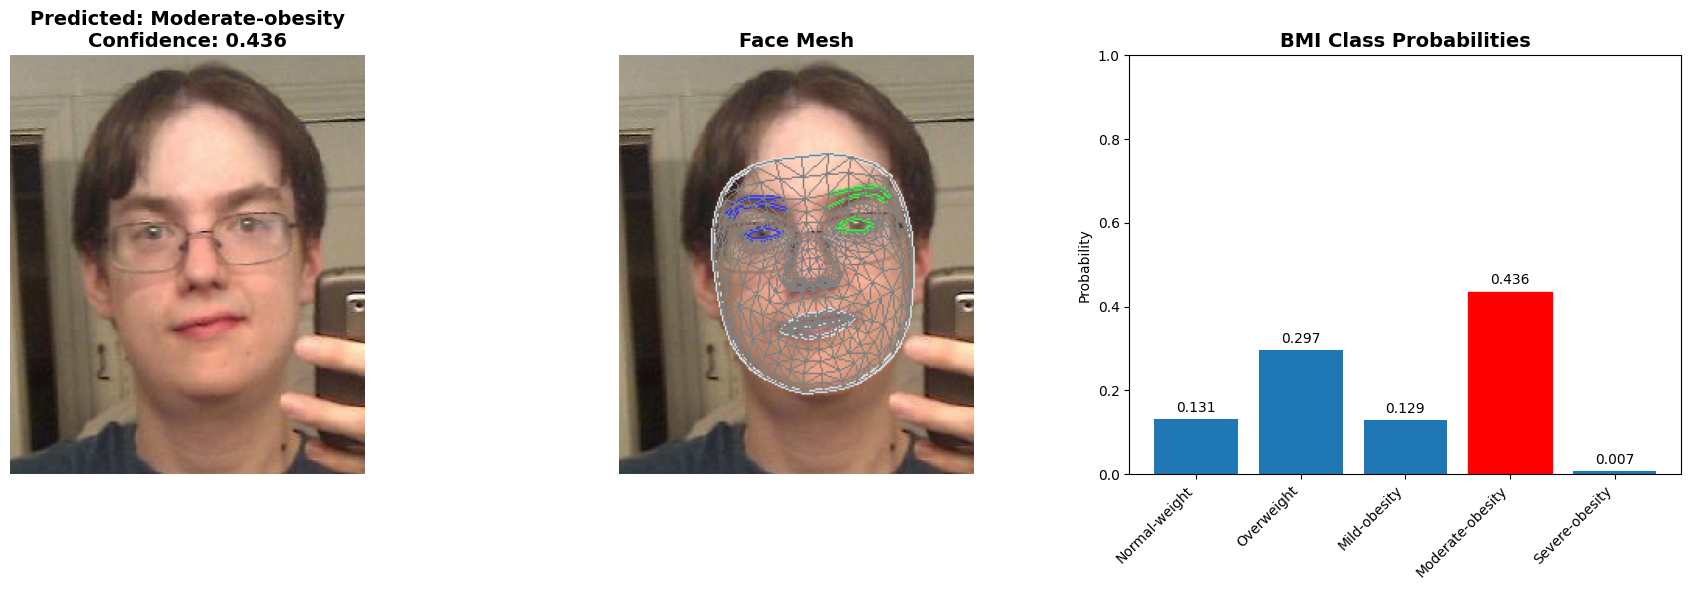


BMI CLASSIFICATION RESULTS
Image: img_19_bmp.rf.2b74eee5c1db92a42e302fba4ad52943.jpg
Predicted Class: Moderate-obesity
Confidence: 0.4357

All Class Probabilities:
  Normal-weight: 0.1311
  Overweight: 0.2968
  Mild-obesity: 0.1291
  Moderate-obesity: 0.4357
  Severe-obesity: 0.0072


In [12]:
# Test BMI prediction with face mesh image
sample_image_path = r"C:\Users\Dell\Documents\GitHub\GlucoZap\ml\bmi\BMI-1\valid\img_19_bmp.rf.2b74eee5c1db92a42e302fba4ad52943.jpg"

# Check if the image exists
if os.path.exists(sample_image_path):
    print("Testing with face mesh...")
    visualize_with_face_mesh(sample_image_path, show_probabilities=True)
else:
    print(f"Image not found: {sample_image_path}")
    
    # Use a sample from the test set
    if 'test_samples' in locals() and test_samples:
        print("\nUsing sample from test set:")
        sample_path = test_samples[0][0]
        visualize_with_face_mesh(sample_path, show_probabilities=True)